<a href="https://colab.research.google.com/github/yonigresearch-wq/ML-workflows/blob/main/Methylation_clock_with_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an epigenetic methylation clock with scikit-learn

Reference articles:
- Horvath, Genome Biology 2013: https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-10-r115#MOESM21
- Varshavsky et al. Cell Reports Methods 2023: https://www.cell.com/cell-reports-methods/fulltext/S2667-2375(23)00211-4


# Data loading & inspection

In [ ]:
# Edited code slightly to upload zip file from pc folder

from google.colab import files
import zipfile
import os

uploaded = files.upload()

os.makedirs('/content/data', exist_ok=True)
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

folder = '/content/data/data/'
datasets = [x for x in os.listdir(folder) if x.endswith('.csv') and x.startswith('GSE')]

tables = []

for dataset in datasets:
    name = dataset.split('.')[0]
    table = pd.read_csv(os.path.join(folder, dataset), index_col=0).transpose()
    table['Source'] = name
    print(dataset, table.shape)
    tables.append(table)

full_table = pd.concat(tables, axis=0, join='outer')

methylation_site_names = [x for x in full_table.columns if x not in ['age', 'Source']]

if os.path.exists(os.path.join(folder, 'site_annotations.csv')):
    methylation_site_annotations = pd.read_csv(os.path.join(folder, 'site_annotations.csv'), index_col=0)
else:
    methylation_site_annotations = pd.read_csv('humanmethylation450_15017482_v1-2.csv', skiprows=7, index_col='IlmnID')
    methylation_site_annotations = methylation_site_annotations.loc[methylation_site_names][['CHR', 'MAPINFO', 'Strand', 'SourceSeq', 'UCSC_RefGene_Name']]
    methylation_site_annotations.to_csv(os.path.join(folder, 'site_annotations.csv'))


Saving data.zip to data.zip
GSE105018.csv (1658, 1026)
GSE87648.csv (382, 2351)
GSE40279.csv (656, 2376)
GSE42861.csv (689, 2376)
GSE103657.csv (586, 995)
GSE64495.csv (113, 2376)
GSE41169.csv (95, 2376)
GSE154566.csv (235, 936)
GSE69270.csv (184, 981)
GSE73103.csv (355, 979)
GSE36054.csv (134, 2376)
GSE55763.csv (2639, 2376)
GSE157131.csv (1218, 2280)
GSE51032.csv (845, 2376)
GSE84727.csv (665, 1027)
GSE147221.csv (679, 2376)
GSE72775.csv (335, 2376)
GSE72680.csv (422, 1048)
GSE30870.csv (20, 2376)


## Inspecting the dataset

Pay attention that for some individuals, not all methylation levels were measured.

In [ ]:
full_table.head()

,age,cg00058879,cg00059225,cg00080081,cg00094518,cg00101260,cg00103778,cg00129827,cg00144180,cg00145253,...,ch.7.135065R,ch.7.2635062R,ch.7.2986028F,ch.7.3189261R,ch.8.103893680R,ch.9.1059422R,cg02650266,cg15803065,cg20119745,cg00266920
GSM2814989,18.0,0.179,0.282,0.242,0.124,0.279,0.338,0.227,0.650,0.220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2815012,18.0,0.110,0.335,0.235,0.105,0.292,0.294,0.222,0.776,0.207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2815117,18.0,0.130,0.349,0.293,0.137,0.311,0.278,0.236,0.660,0.217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2815104,18.0,0.093,0.296,0.220,0.121,0.348,0.301,0.240,0.732,0.228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2814572,18.0,0.111,0.274,0.211,0.088,0.321,0.292,0.188,0.725,0.216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Inspecting the metadata for each methylation site.
- IlmnID: Name.
- CHR: Chromosome.
- MAPINFO: start position along the reference genome.
- STRAND: on which strand is the CpG site located.
- Source: The corresponding DNA fragment

In [ ]:
methylation_site_annotations.head()

,CHR,MAPINFO,Strand,SourceSeq,UCSC_RefGene_Name
IlmnID,,,,,
cg00058879,22.0,40082173.0,F,GGGCGGCCAGGCTGCTGGTGCTGCTGAACTTCCTGGCGGGCGTGAG...,CACNA1I;CACNA1I
cg00059225,5.0,151304357.0,F,GCAGGGAGCCAACAGACACGCTGGAGTTTAACAAACAGCAATACTC...,GLRA1;GLRA1;GLRA1;GLRA1
cg00080081,17.0,33701776.0,F,CGCACGTTTGTTAAAATGAGGTCATAATGTTCATGCTGTTTCATAA...,SLFN11;SLFN11;SLFN11;SLFN11;SLFN11
cg00094518,7.0,130418549.0,F,TCTGGGCGGACTTGCGCGGCAGCTCTGGCGAGGGCTCCTGGGAGAA...,KLF14
cg00101260,17.0,53426657.0,R,CGGTTCCAATGAAGCGTGGAGCATCTGTGATTCCAATCCTGAGGGG...,NaN


# Part I: Exploratory Data Analysis

1.	For each CpG site, calculate the Spearman correlation coefficient between its methylation level and the age of the donor. Display the result as a histogram and comment on the findings.


In [ ]:
# Compute spearman correlations using for loop over numeric columns and age
# (less computationally intense than computing entire correlation matrix and then indexing)

from scipy.stats import spearmanr

numeric_table = full_table.select_dtypes(include=[np.number])
numeric_table = numeric_table.dropna(subset=['age'])

correlations = {}
for col in numeric_table.columns:
    if col != 'age':
        coef, _ = spearmanr(numeric_table['age'], numeric_table[col], nan_policy='omit')
        correlations[col] = coef

Spearman_correlation = pd.Series(correlations).sort_values(ascending=False)
Spearman_correlation

,0
cg16867657,0.939139
cg22454769,0.900077
cg06639320,0.879080
cg21572722,0.853108
cg04875128,0.849220
...,...
cg00573770,-0.735663
cg05412028,-0.745590
cg08128734,-0.777279
cg26685941,-0.809738


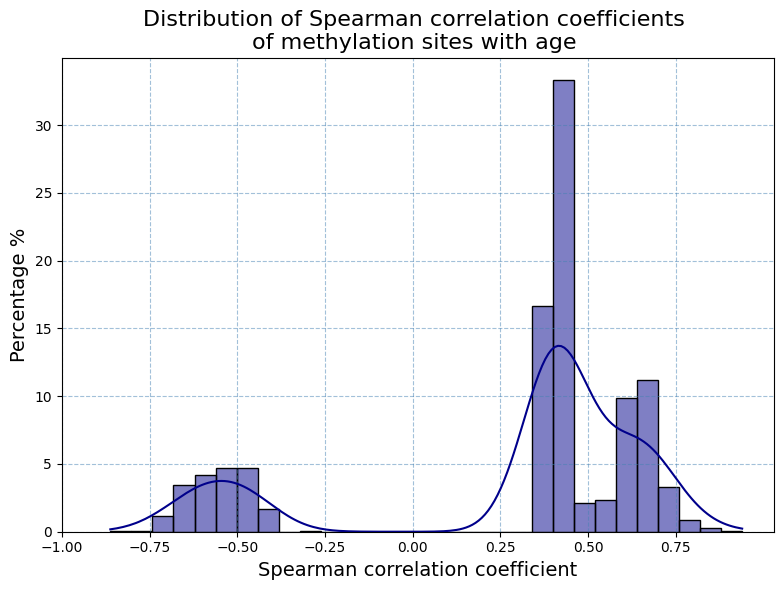

In [ ]:
# Display correlation coefficients graphically, using a histogram

plt.figure(figsize=(8, 6))
sns.histplot(Spearman_correlation, stat="percent", kde = True, bins=30, color='darkblue', edgecolor='black')

plt.title('Distribution of Spearman correlation coefficients \nof methylation sites with age ', fontsize=16)
plt.xlabel('Spearman correlation coefficient', fontsize=14)
plt.ylabel('Percentage %', fontsize=14)
plt.grid(True, linestyle ='--', alpha=0.5, color='steelblue')
plt.tight_layout()
plt.xticks(np.arange(-1.0, 1., 0.25), fontsize=10)
plt.show()


###**Conclusion:**
It would seem that almost all sited are at least moderately correlated with age, while most correlations range between approx. 0.35 and 0.75 (in absolute value), with very few sites having correlation coefficients outside of this interval.
Furthermore, it is evident that most of the sites are positively correlated with age, while much less exhibit negative correlations with age.

2.	For the 5 CpG sites with highest and lowest Spearman correlation coefficient values, visualize the relationship between methylation level and age using a scatter plot. Comment on the findings.



# **Make sure this works correctly**


In [ ]:
# First lets see which sites are most/least correlated with age:

Top_corr = pd.Series(Spearman_correlation).sort_values(ascending=False)

pd.concat([Top_corr.head(), Top_corr.tail()], axis = 0)



,0
cg16867657,0.939139
cg22454769,0.900077
cg06639320,0.879080
cg21572722,0.853108
cg04875128,0.849220
cg00573770,-0.735663
cg05412028,-0.745590
cg08128734,-0.777279
cg26685941,-0.809738
cg19283806,-0.862045


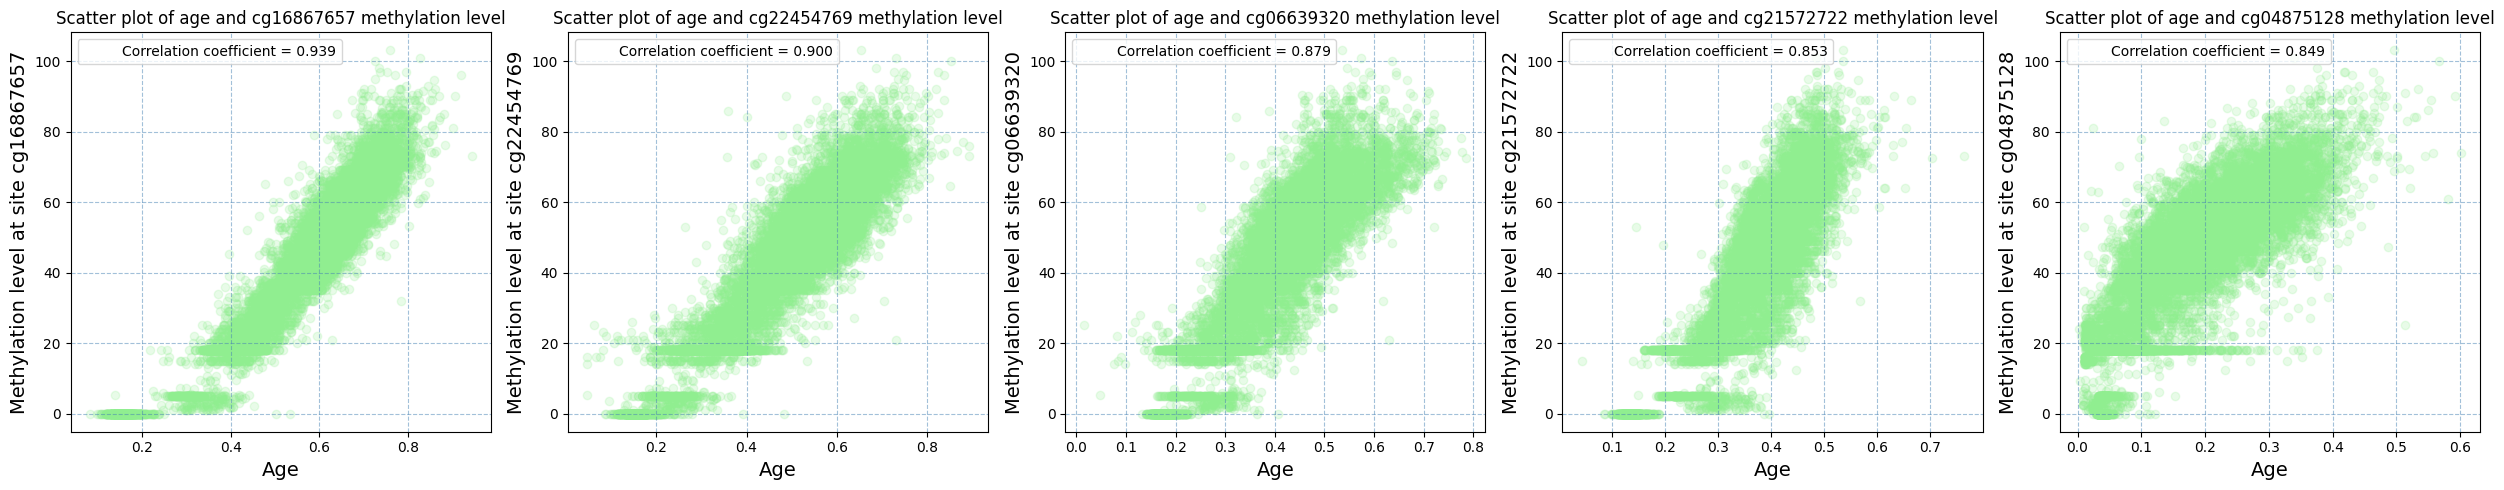

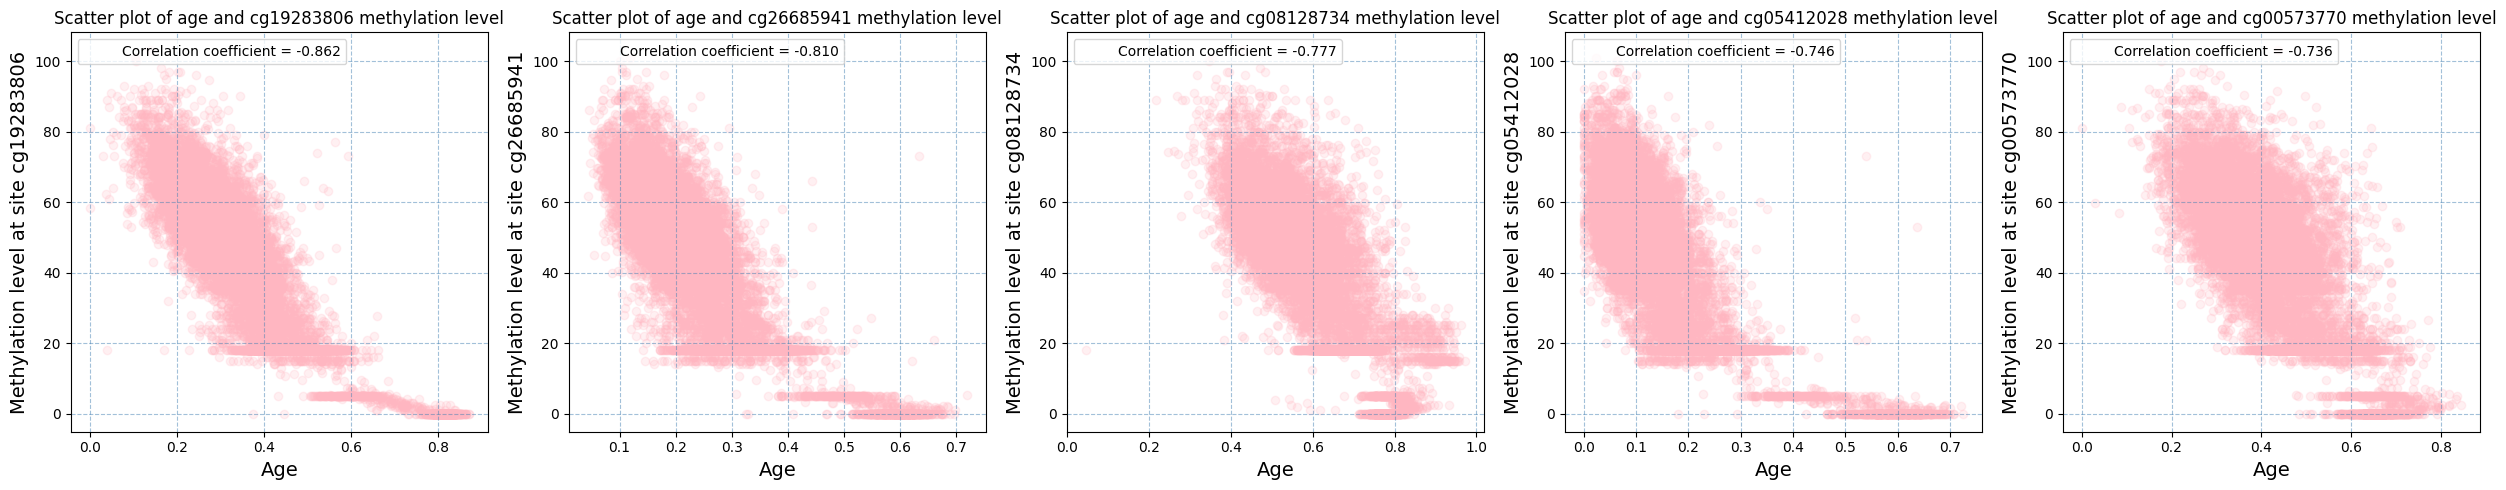

In [ ]:
# Visualize relationships using scatter plots

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):

    # Most positively correlated sites (green)

    site = Top_corr.index[i]
    coef, _ = spearmanr(numeric_table['age'], numeric_table[site], nan_policy='omit')

    ax = axes[i]
    ax.scatter(full_table[site], full_table['age'], color='lightgreen', alpha=0.2)
    ax.plot([], [], ' ', label=f'Correlation coefficient = {coef:.3f}')
    ax.set_title(f'Scatter plot of age and {site} methylation level', fontsize=12)
    ax.set_xlabel('Age', fontsize=14)
    ax.set_ylabel(f'Methylation level at site {site}', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5, color='steelblue')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):

    # most negatively correlated sites (pink)

    j = i + 1

    site = Top_corr.index[-j]
    coef, _ = spearmanr(numeric_table['age'], numeric_table[site], nan_policy='omit')

    ax = axes[i]
    ax.scatter(full_table[site], full_table['age'], color='lightpink', alpha=0.2)
    ax.plot([], [], ' ', label=f'Correlation coefficient = {coef:.3f}')
    ax.set_title(f'Scatter plot of age and {site} methylation level', fontsize=12)
    ax.set_xlabel('Age', fontsize=14)
    ax.set_ylabel(f'Methylation level at site {site}', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.5, color='steelblue')
    ax.legend(loc='upper left')

plt.tight_layout()
plt.show()



### **Conclusion**
The top 5 positively correlated sites are more highly correlated (in absolute value) than the top 5 negatively correlated sites. Furthermore, the relationships seem to be more monotonic rather than linear.

3.	Select all sites located along Chromosome 10 and reorder them by their location along the genome. Calculate the matrix of Spearman correlation coefficients between all pairs of methylation levels and visualize as a heatmap. Comment on the findings.


<Axes: >

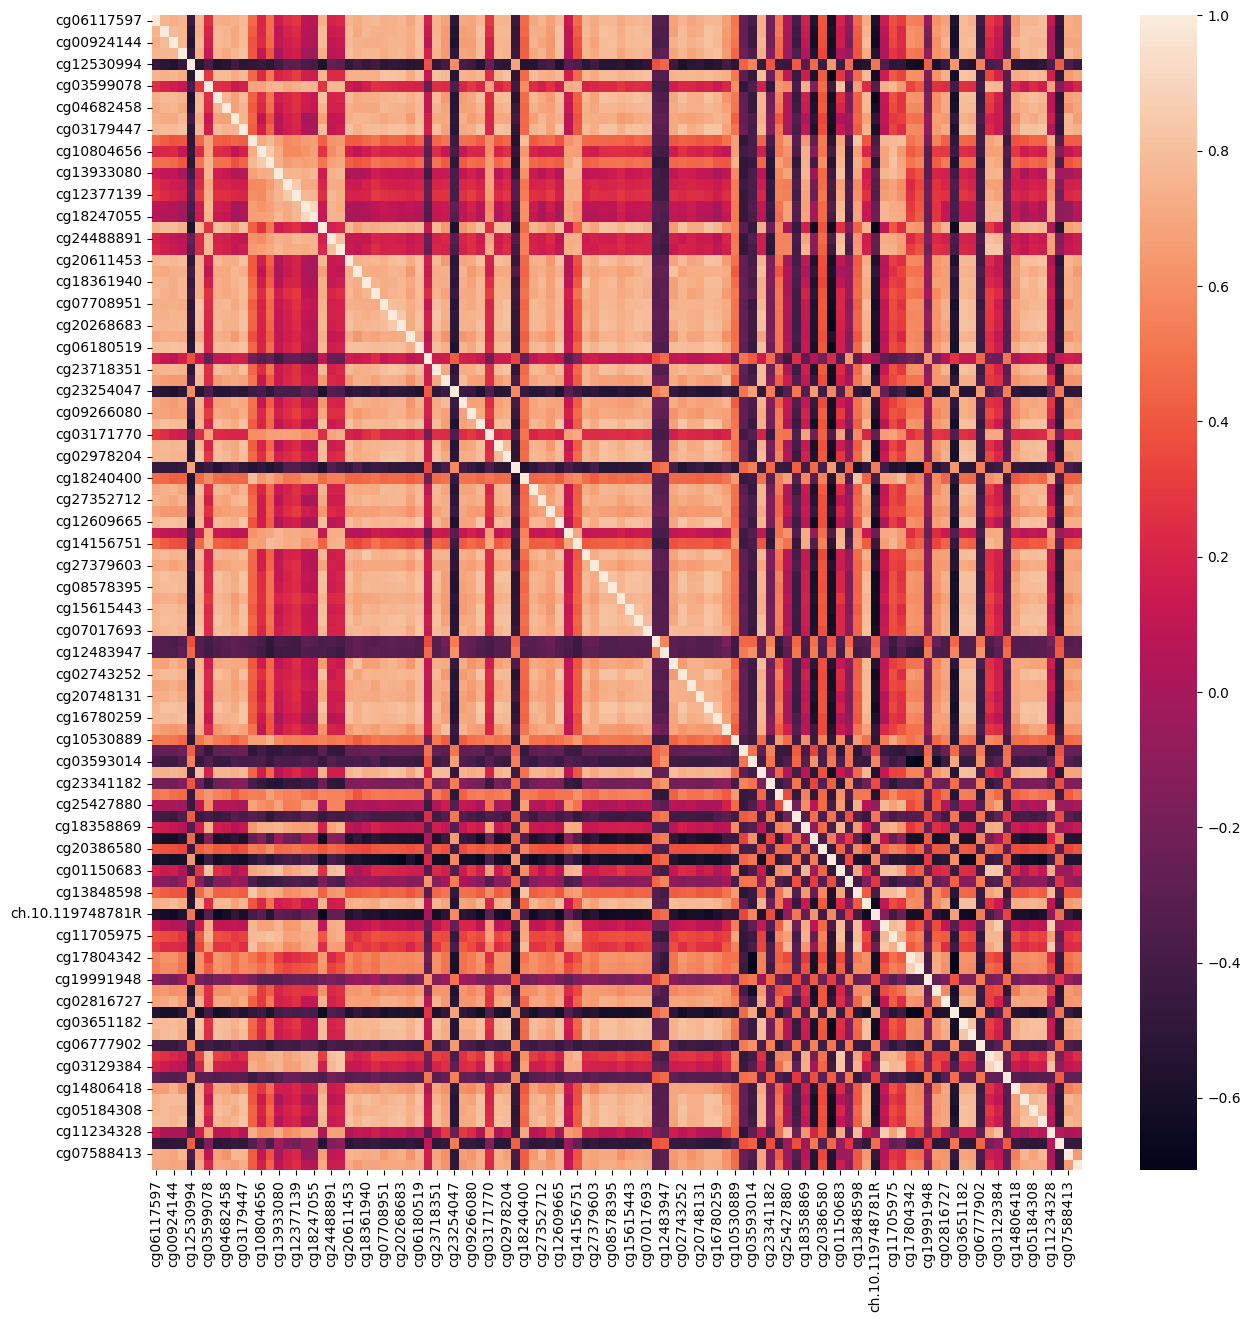

In [ ]:
# Take relevant subset of data

CHR_10 = methylation_site_annotations[methylation_site_annotations['CHR'] == 10]
CHR_10_table = full_table[CHR_10.sort_values(by='MAPINFO').index]

# Calculate Spearman correlation matrix

correlation_matrix = CHR_10_table.corr(method='spearman')

# Create heatmap for visualization of correlation matrix

fig, axes = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation_matrix)

### **Heatmap findings**

We can see that both proximity between sites and location on the chromosome can have a strong influence on the correlation between methylenation levels.
for example, the first half (approx.) of the sites on the chromosome tend to be positively correlated with each other, with only a few exceptions. the second half of sites don't show any specific trend with each other or with the first half of sites. This could indicate sites positioned later on the chromosome have less stable trends in methylenation level, and perhaps the sites which are located at the earlier positions of the chromosome are more informative.

# Part II: Data Partition

Here, we perform the data partition, splitting the dataset into a training and a test set. We then split the training set into five folds for cross-validation purpose.

- The dataset was compiled from 19 separate studies. To account for potential "batch effects" (i.e., distribution shift from one study to the other), we use one of the study as test set.

- For the cross-validation, we use a stratified K-fold approach.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
X , Y = full_table[methylation_site_names], full_table['age']
study = full_table['Source'] # The study chosen from.

test_set = (study == 'GSE84727')

X_train, Y_train = X[~test_set], Y[~test_set]
X_test, Y_test = X[test_set], Y[test_set]


Y_train_binned = KBinsDiscretizer(n_bins=20,encode='ordinal').fit_transform(Y_train.to_numpy()[:,None])[:,0]
skf = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
skf.get_n_splits(X_train,Y_train_binned)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


5

4.	Report the number of samples per study and visualize the age distribution for each of the 19 studies, using a boxplot. Comment on the findings.



In [ ]:
# First lets see how many obs. there are in each study

study_n = study.value_counts()
study_n

,count
Source,
GSE55763,2639
GSE105018,1658
GSE157131,1218
GSE51032,845
GSE42861,689
GSE147221,679
GSE84727,665
GSE40279,656
GSE103657,586


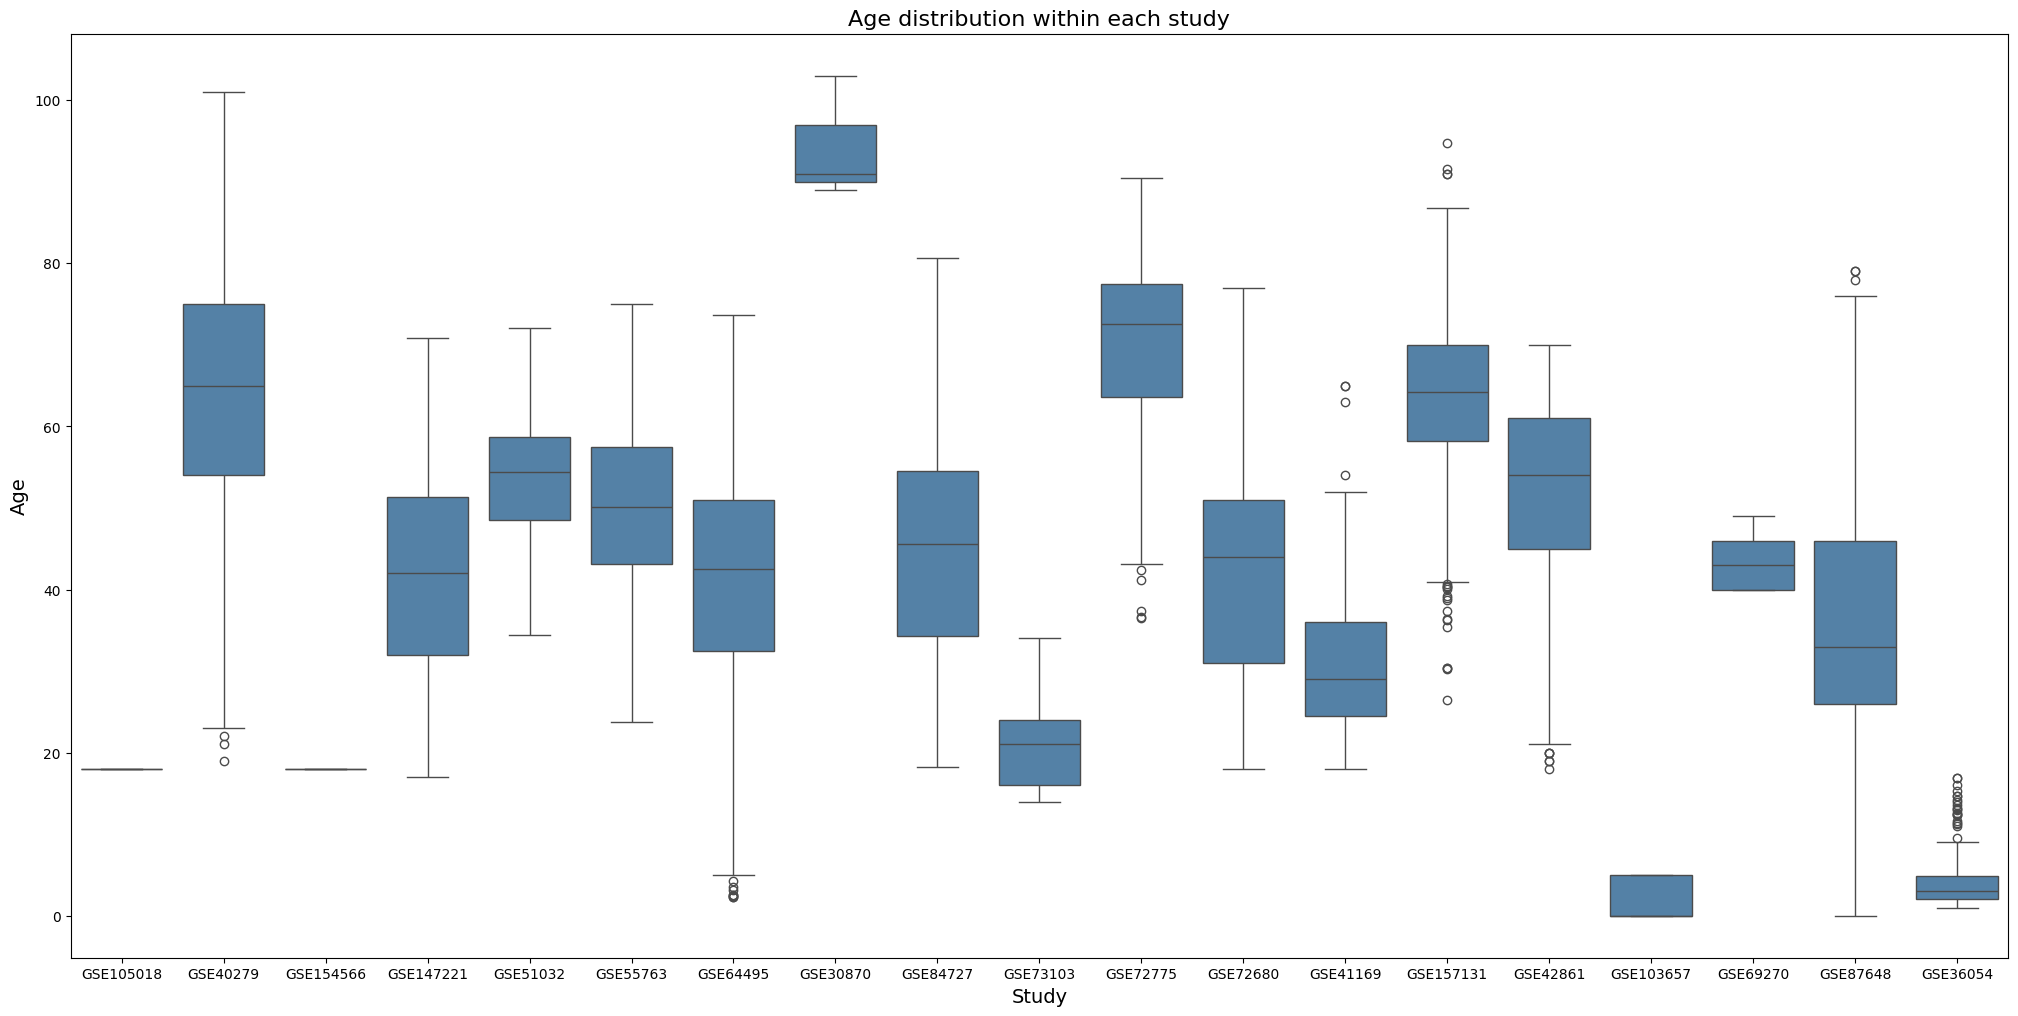

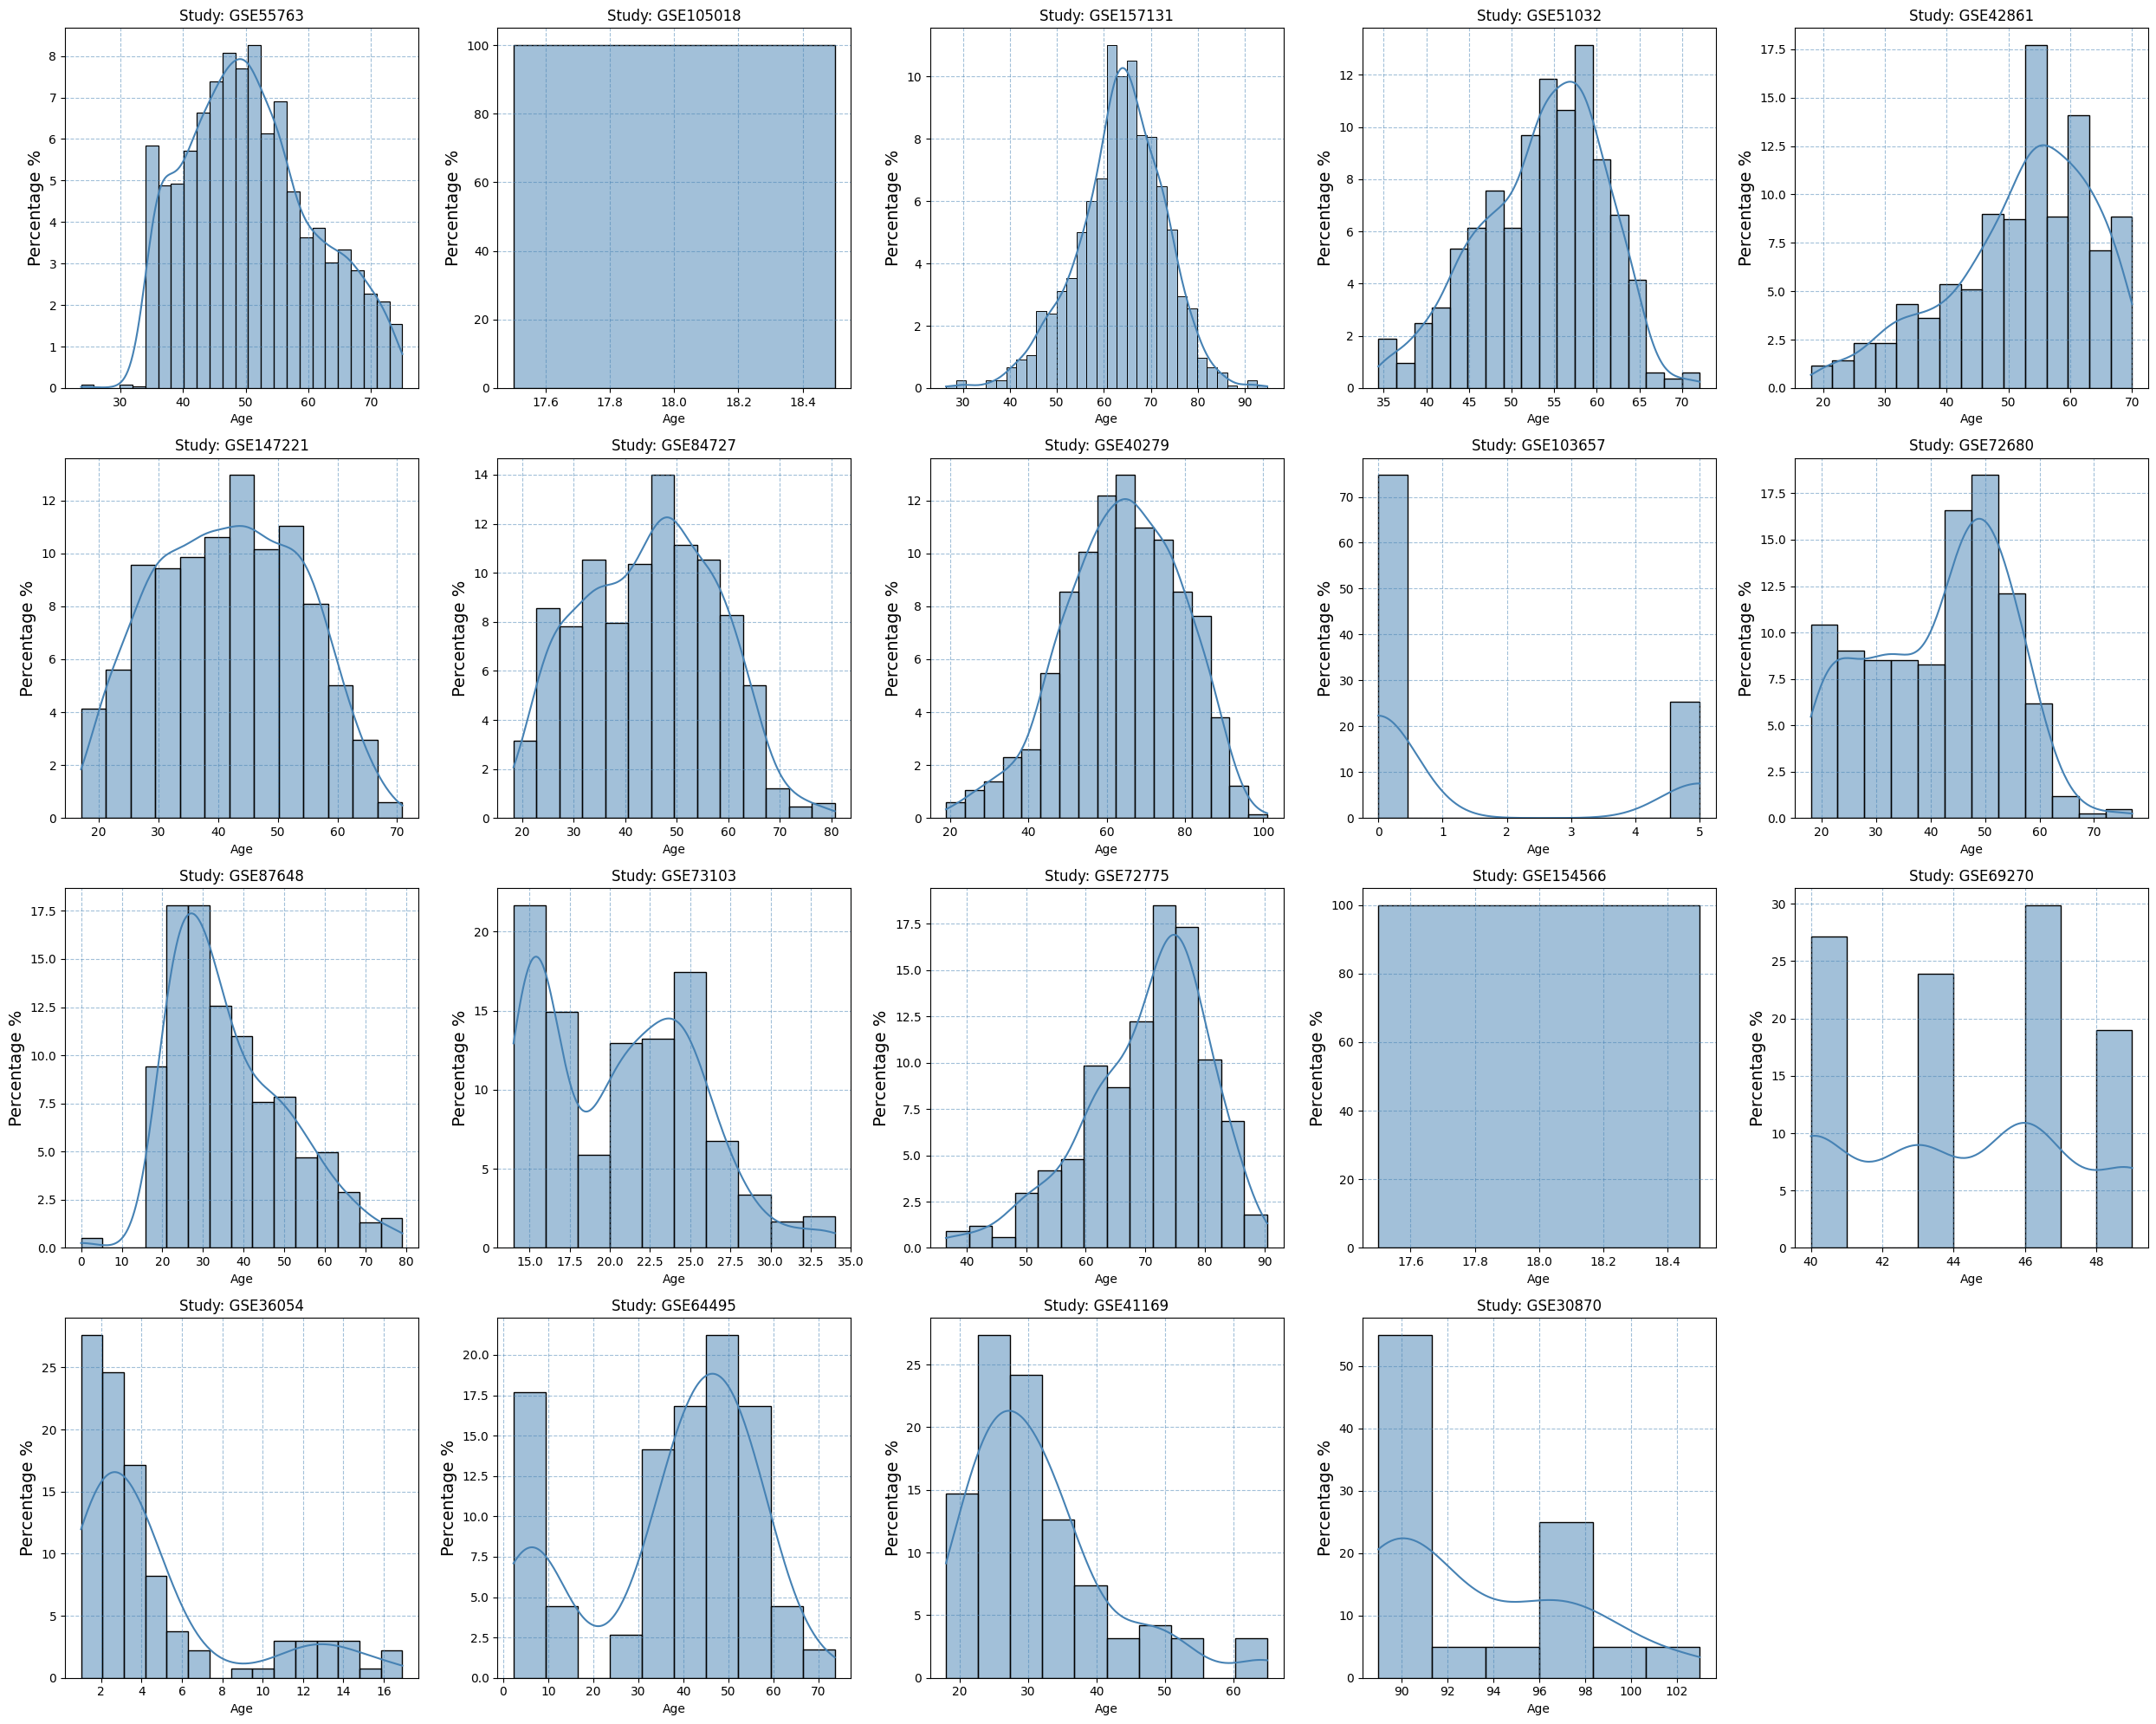

In [ ]:
# Create boxplot of age dist. within study groups

fig, axes = plt.subplots(1,figsize=(25, 12))
sns.boxplot(x = study, y = 'age', data = full_table, ax = axes, color = "steelblue")
axes.set_title('Age distribution within each study', fontsize=16)
axes.set_xlabel('Study', fontsize=14)
axes.set_ylabel('Age', fontsize=14)

# Create histogram of age dist. within each study

fig, axes = plt.subplots(4, 5, figsize=(25, 20))
axes = axes.flatten()
axes[19].axis('off')


for stud in range(len(study_n)):

    study_index = study_n.index[stud]
    study_age = full_table[full_table['Source'] == study_index]['age']

    ax = axes[stud]
    sns.histplot(study_age, alpha=0.5, color='steelblue', kde=True, ax=ax, stat = "percent")

    ax.set_title(f"Study: {study_index}", fontsize=12)
    ax.set_xlabel("Age")
    ax.set_ylabel('Percentage %', fontsize=14)
    ax.grid(True, linestyle ='--', alpha=0.5, color='steelblue')

plt.tight_layout()
plt.show()

### **Conclusion:**

Its clear that age is distributed quite differently among the different studies. For example, some studies' age ranges from 0-90, and seems to be approx. normally distributed, while in other studies, age ranges only from 17-19. Other studies' age seems to be distributed more uniformly rather than normally.

5.	Read how the partition between train and test was done on the notebook.
a.	Why did we use dataset “GSE84727” as a test set rather than by using a random split?  
b.	Why did we use a stratified split for the training set rather than a random split or a grouped split?



### **Reasoning behind test set selection and stratified split**

* We used dataset GSE84727 as a test set because it approximately 5% of the data (okay test set size) and it has a wide range of ages. Using a study sample as a test set also insures (or makes much more likely) that it does not depend on certain folds more than others. this can be important in genetic/biological studies, because observations within a specific sample may be more gentically related to themselves compared to other samples. In this way, we can avoid biasing the analysis. Furthermore, This is much more closer to reality - can our model generalize to a real study sample?

* We use a stratified split to insure that age (or age bins) are evenly distributed among folds. This is important since age is the dependent variable. This would not be insured if we were to use random splits. grouped splits could be useful in some situations, but here it would give us folds with mutually exclusive age bins, which does not make sense in our context, when we are trying to predict age.



# Part III: Training and evaluating a linear model

Build a scikit-learn Pipeline consisting of:
-	An imputer for missing values (SimpleImputer)
-	Top-K feature selection using the F-statistics of the correlation coefficient (functions: SelectKBest and f_regression).
-	Ridge Regression.
For each of the following values of K: [5,10,20,30,50,100,500,1000], select the optimal L2 regularization strength over the range by cross-validation.

6.	Report the performance of the model on the test set as a table with error bars (defined as the standard deviation of the absolute error, divided by the square root of the test set size).
How does the performance evolve with K?


In [ ]:
# Import relevant tools

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

# Define k values, penalties and predefined folds

K_vals = [5, 10, 20, 30, 50, 100, 500, 1000]
ridge_penalties = [0.0001, 0.001, 0.01, 0.1, 1, 10, 20]
splits = list(skf.split(X_train, Y_train_binned))

Final_results = []

# Loop over values of K

for k in K_vals:

    print(f"K = {k}") # for sanity

    # Execute pipeline

    pipeline = Pipeline([
          ("imputer", SimpleImputer(strategy="mean")),
          ("select", SelectKBest(score_func=f_regression, k=k)),
          ("ridge", Ridge())
          ])

    # Grid search over ridge penalties, using our predefined folds

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid={"ridge__alpha": ridge_penalties},
        cv=splits,
        scoring="neg_mean_absolute_error")

    grid_search.fit(X_train, Y_train)
    y_test_pred = grid_search.predict(X_test)

    # Define and save output parameters

    abs_errors = np.abs(Y_test - y_test_pred)
    Test_MAE = np.mean(abs_errors)
    Error_bar = np.std(abs_errors) / np.sqrt(len(Y_test))
    Optimal_penalty = grid_search.best_params_["ridge__alpha"]

    Final_results.append({
        "K": k,
        "Test MAE": Test_MAE,
        "Error Bar": Error_bar,
        "Optimal Ridge Penalty": Optimal_penalty
    })

Results_table = pd.DataFrame(Final_results)
Results_table


K = 5
K = 10
K = 20
K = 30
K = 50
K = 100
K = 500
K = 1000


,K,Test MAE,Error Bar,Optimal Ridge Penalty
0,5,4.562911,0.144014,0.0001
1,10,4.352325,0.135099,0.0100
2,20,4.324756,0.133156,0.0100
3,30,3.938663,0.125587,0.0001
4,50,3.584626,0.118703,0.0001
5,100,2.875686,0.094024,0.1000
6,500,2.305741,0.078524,1.0000
7,1000,2.196097,0.077716,10.0000


### **Conclusion**


Its clear that as we take more features (larger K), the optimal ridge penalty is larger. This is intuitive, since we taking a larger k requires a larger penalty to compensate for the larger feature space. taking a larger K (and the optimal ridge penalty) seems to produce better results in terms of mean absolute error.

7.	For K=50, plot the feature importance of the selected sites.
Are some chromosomes over-represented among these sites?

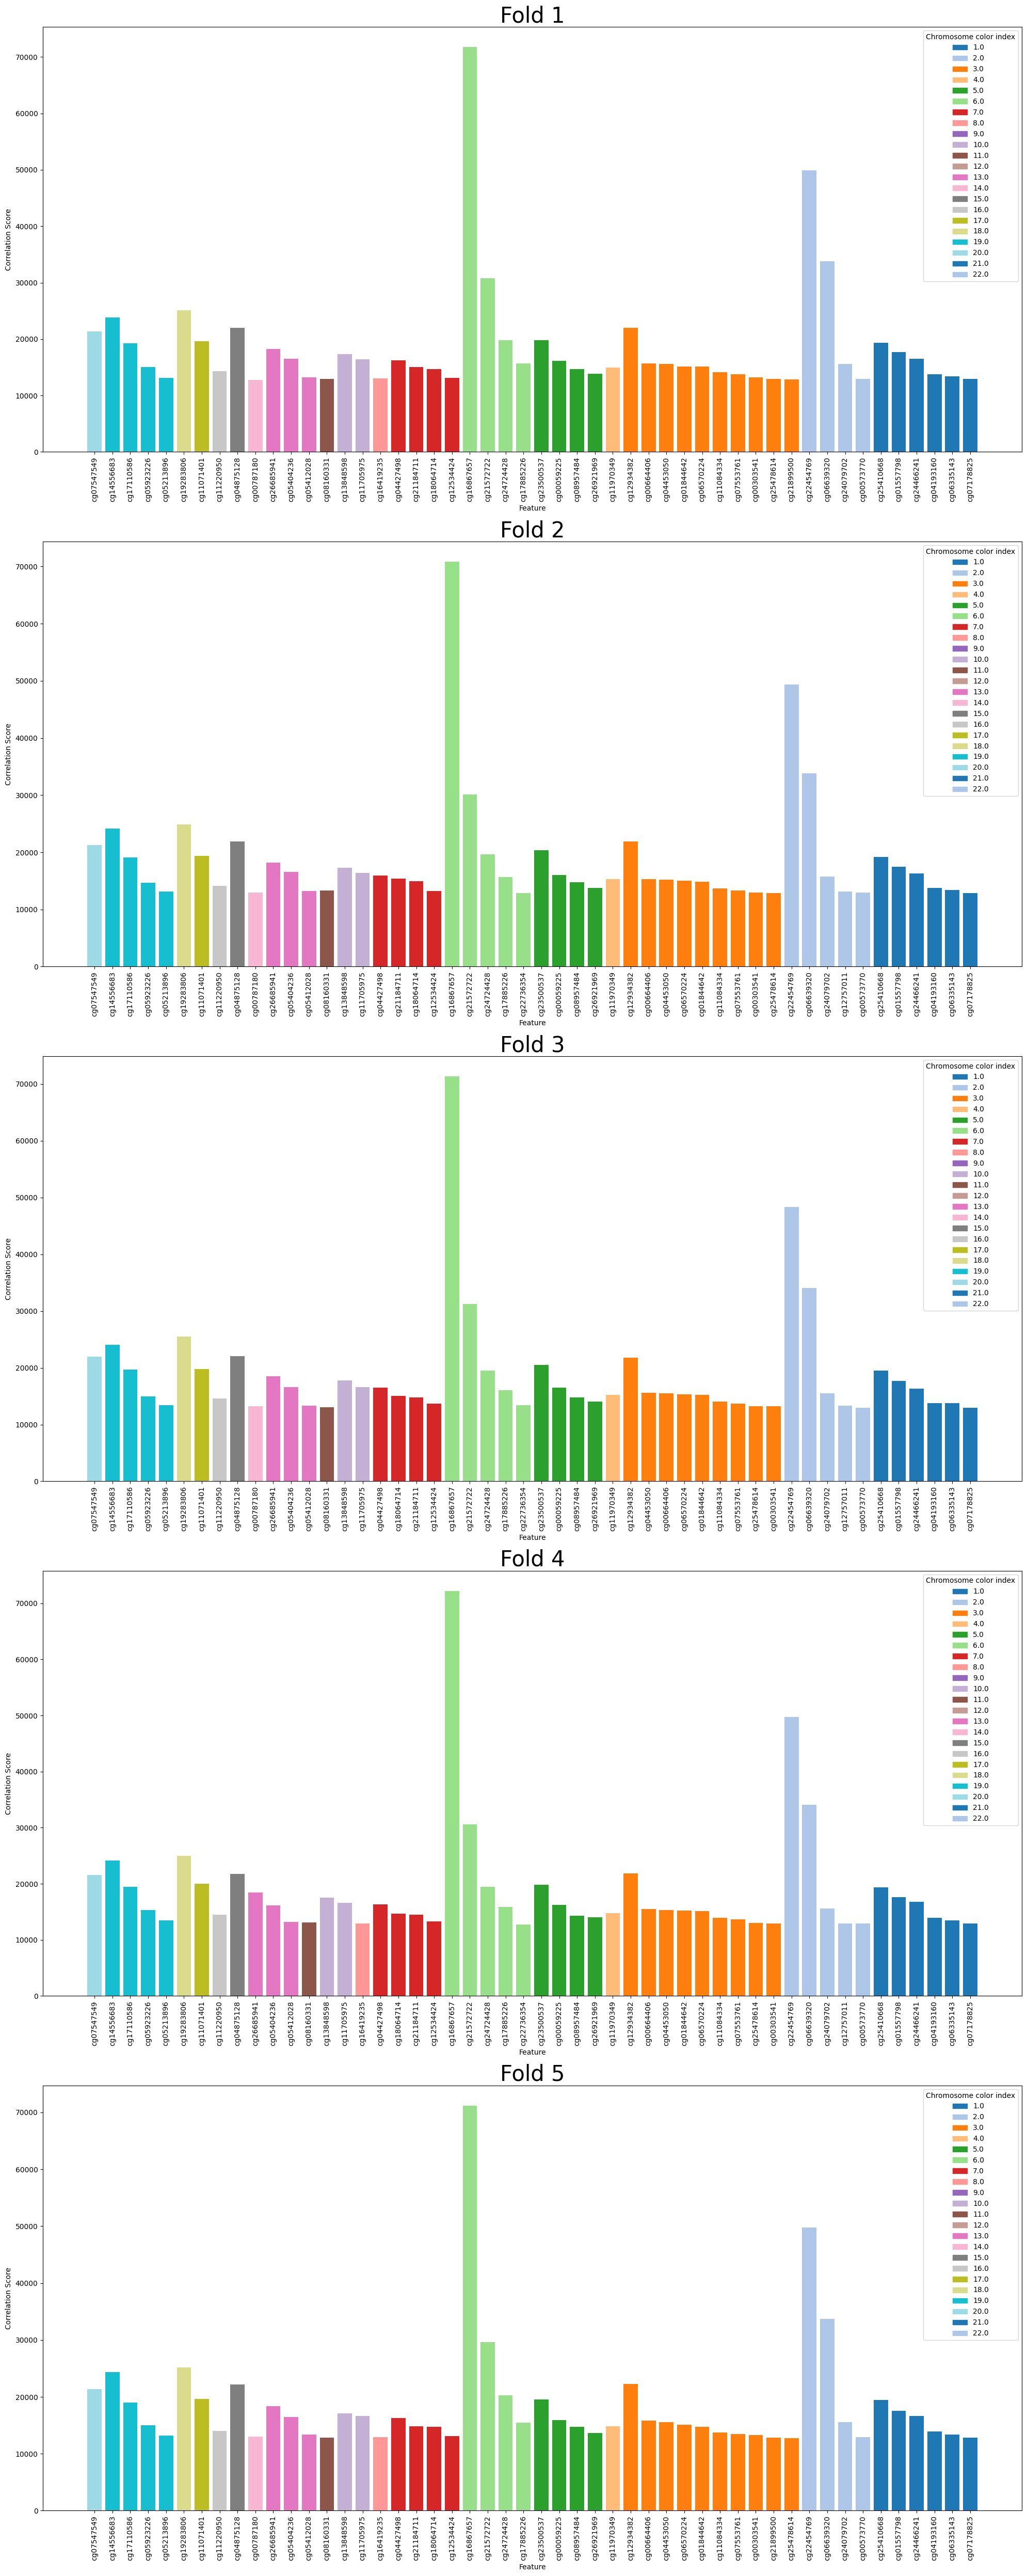

In [ ]:
K = 50

# Create pipeline

pipeline = Pipeline([
          ("imputer", SimpleImputer(strategy="mean")),
          ("select", SelectKBest(score_func=f_regression, k=K))
          ])

features_and_scores_by_split = {}

# Color coordinate chromosomes for bar plot

unique_chromosomes = methylation_site_annotations['CHR'].unique()
unique_chromosomes = sorted(unique_chromosomes, key=lambda x: (str(x) if isinstance(x, int) else x))

chromosome_color_dict = dict(zip(
    unique_chromosomes,
    sns.color_palette("tab20", len(unique_chromosomes))
))

fig, axes = plt.subplots(5, 1, figsize=(20, 50))

# Execute pipeline and create bar plot colored by chromosome for each fold

for i, split in enumerate(splits):

    X_tr, Y_tr = X_train.iloc[split[0]], Y_train.iloc[split[0]]
    X_val, Y_val = X_train.iloc[split[1]], Y_train.iloc[split[1]]

    X_tr.columns = methylation_site_names
    X_val.columns = methylation_site_names

    Pipe = pipeline.fit(X_tr, Y_tr)

    top_50_indices = Pipe.named_steps['select'].get_support(indices=True)
    top_50_features = X_tr.columns[top_50_indices]
    top_50_scores = Pipe.named_steps['select'].scores_[top_50_indices]
    top_50_chromes = methylation_site_annotations.loc[top_50_features]['CHR']

    # Save top 50 features for each fold

    features_and_scores_by_split[f"split_{i}"] = list(zip(top_50_features, top_50_scores, top_50_chromes))

    # Create the bar plot

    df = pd.DataFrame({
        "Feature": top_50_features,
        "Score": top_50_scores,
        "Chromosome": top_50_chromes
    }).sort_values(["Chromosome", "Score"], ascending=False)

    bar_colors = df["Chromosome"].map(chromosome_color_dict)

    ax = axes[i]
    ax.bar(df["Feature"], df["Score"])
    ax.set_title(f"Fold {i+1}", size = 30)
    ax.set_xlabel("Feature")
    ax.set_ylabel("Correlation Score")
    ax.tick_params(axis='x', labelrotation=90)
    ax.bar(df["Feature"], df["Score"], color=bar_colors)

    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in chromosome_color_dict.values()]
    ax.legend(handles, chromosome_color_dict.keys(), title="Chromosome color index")

plt.tight_layout()
plt.show()


8.	For each of the five folds, the selected sites may be different. How many sites are found in all five folds? In at least 2 folds? Discuss the findings.

In [ ]:
# Import Counter

from collections import Counter

# Collect all features from the 5 folds

All_features = [
    feature[0] for fold in features_and_scores_by_split.values() for feature in fold
]

feature_counts = Counter(All_features)

# Count number of sites that appear in at leat 2 folds or in all folds

Ns = [2, 5]

for n in Ns:

    Common_features = {feature for feature, count in feature_counts.items() if count >= n}

    if n<5:

        print(f"{len(Common_features)} features appear in at least {n} folds.")

    else:

        print(f"{len(Common_features)} features appear in all {n} folds.")


52 features appear in at least 2 folds.
47 features appear in all 5 folds.


### **Conclusion**

Firstly, note that there are 47 common sites which are considered important across all folds. Across at least two folds there are 52. This indicates that there is very little variation in the sites that are considered important across the 5 folds, and that these sites are most likely very stable. Furthermore, it seems that some chromosomes are indeed over-represented among the top sites (this can be seen in the color coding in the bar plot, where some colors are more frequent than others). These chromosomes are stable over the different folds (makes sence since 47 of the 50 sites in the folds are shared), which implies that sites along these chromosomes may be very informative, perhaps pointing to genetic mechanisms involved in aging which are related to these chromosoms (perhaps encoded in DNA).     

# Part IV: Automated feature selection by LASSO
Replace the previous Pipeline by a Pipeline consisting of:
-	An imputer for missing values (SimpleImputer)
-	LASSO Regression.

9.	For various values of the L1 regularization strength, fit a model (on the full training set) and calculate the performance on the test set as well as the number of CpG sites with non-zero coefficients. Plot the test set performance as function of the number of sites for both models.

Why would feature selection with LASSO outperform feature selection by Pearson correlation? Conversely, why would Ridge outperform LASSO? Suggest a “best-of-both worlds” solution.



In [ ]:
# Import relevant tools

from sklearn.linear_model import Lasso

# Define penalties

Lasso_penalties = [0.0005, 0.001, 0.005, 0.01, 0.1, 1]

Final_results_lasso = []

for l in Lasso_penalties:

    print(f"L = {l}") # for sanity

    # Execute pipeline

    pipeline = Pipeline([
          ("imputer", SimpleImputer(strategy="mean")),
          ("lasso", Lasso(alpha=l, max_iter=5000))
          ])

    pipeline.fit(X_train, Y_train)
    y_test_pred = pipeline.predict(X_test)

    # Define and save output parameters

    abs_errors = np.abs(Y_test - y_test_pred)
    Test_MAE = np.mean(abs_errors)
    Error_bar = np.std(abs_errors) / np.sqrt(len(Y_test))
    Lasso_penalty = l

    # Number of non-zero coefficients

    Lasso_mod = pipeline.named_steps['lasso']
    Nonzero_coeffs = np.count_nonzero(Lasso_mod.coef_)

    Final_results_lasso.append({
        "Test MAE": Test_MAE,
        "Error Bar": Error_bar,
        "Lasso Penalty": Lasso_penalty,
        "Non-zero Coefficients": Nonzero_coeffs
    })

Results_table_lasso = pd.DataFrame(Final_results_lasso)
Results_table_lasso


L = 0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.833e+04, tolerance: 5.026e+02
  model = cd_fast.enet_coordinate_descent(


L = 0.001


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.813e+04, tolerance: 5.026e+02
  model = cd_fast.enet_coordinate_descent(


L = 0.005


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.876e+03, tolerance: 5.026e+02
  model = cd_fast.enet_coordinate_descent(


L = 0.01
L = 0.1
L = 1


,Test MAE,Error Bar,Lasso Penalty,Non-zero Coefficients
0,2.585128,0.089533,0.0005,1140
1,2.596201,0.088487,0.0010,727
2,2.674160,0.087418,0.0050,227
3,2.926113,0.093587,0.0100,122
4,3.038620,0.102742,0.1000,21
5,6.035247,0.171370,1.0000,5


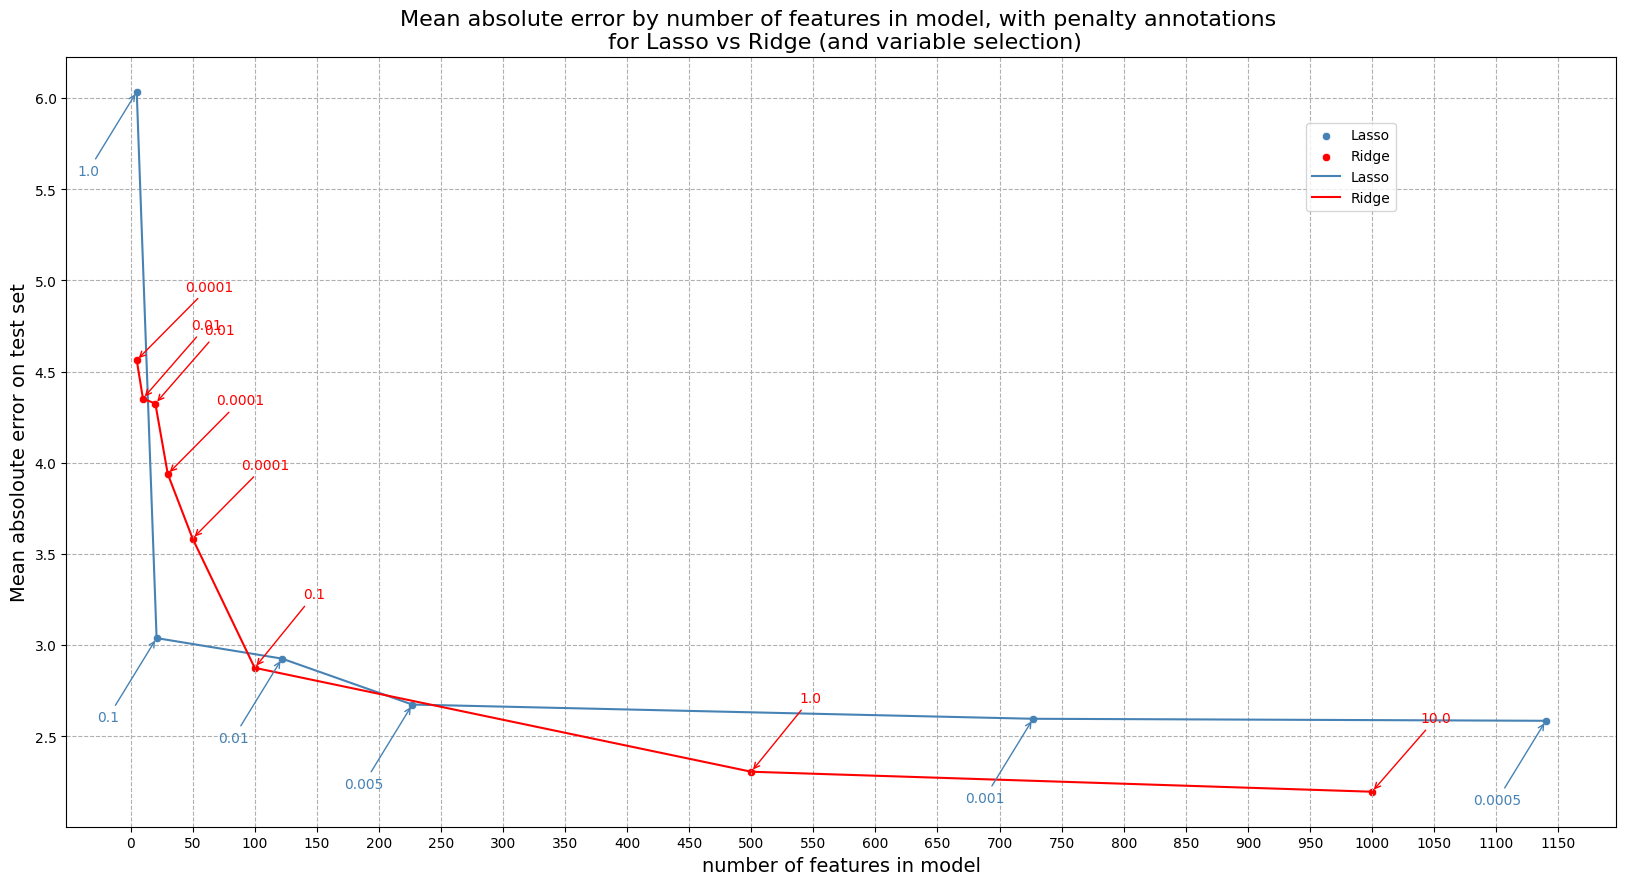

In [ ]:
# Plot Lasso vs Ridge with variable selection

fig, axes = plt.subplots(1, 1, figsize=(20, 10))

sns.scatterplot(x=Results_table_lasso['Non-zero Coefficients'], y=Results_table_lasso['Test MAE'], ax = axes, color = "steelblue",  label="Lasso", alpha=1)
sns.scatterplot(x=Results_table['K'], y=Results_table['Test MAE'], ax = axes, color = "red", label = "Ridge", alpha=1)
sns.lineplot(x=Results_table_lasso['Non-zero Coefficients'], y=Results_table_lasso['Test MAE'], ax = axes, color = "steelblue",  label="Lasso")
sns.lineplot(x=Results_table['K'], y=Results_table['Test MAE'], ax = axes, color = "red", label = "Ridge")
plt.grid(True, linestyle='--', alpha=1)
plt.title(f'Mean absolute error by number of features in model, with penalty annotations \n for Lasso vs Ridge (and variable selection)', fontsize=16)
plt.xlabel('number of features in model', fontsize=14)
plt.ylabel('Mean absoloute error on test set', fontsize=14)
plt.legend(loc=(0.8, 0.8))
plt.xticks(np.arange(0, 1200, 50))

for i, penalty in enumerate(Results_table_lasso['Lasso Penalty']):
    plt.annotate(penalty, (Results_table_lasso['Non-zero Coefficients'][i], Results_table_lasso['Test MAE'][i]),
                 textcoords="offset points", xytext=(-35,-60), ha='center', color= 'steelblue',  arrowprops=dict(arrowstyle="->", color='steelblue'))

for i, penalty in enumerate(Results_table['Optimal Ridge Penalty']):
    plt.annotate(penalty, (Results_table['K'][i], Results_table['Test MAE'][i]),
                 textcoords="offset points", xytext=(35,50), ha='left', color= 'red',  arrowprops=dict(arrowstyle="->", color='red'))

plt.show()

10.	Why would feature selection with LASSO outperform feature selection by Pearson correlation? Conversely, why would Ridge outperform LASSO? Suggest a “best-of-both worlds” solution.

### **Intuition behind Ridge and Lasso performance**

Lasso exhibits better results than Pearson correlation when it comes to feature selction because L1 regularization induces sparsity by bringing many coeficients to 0. this compared to pearson correlation, where we simply chose the number of variables we wanted to remain in the model.
Ridge regression on the other hand, is not a variable selection tool, beacuse all the features remain in the model. It is however a useful regularization tool. The most likely reason that Ridge outperformed Lasso in this case, is that there are many features in the data that have are moderately correlated with age (we also saw this when we examined the spearman correlations). When using ridge regression, these features have less influence, but remain in the model. With Lasso however, many of these features' coefficients go to zero, and therefore they do not participate in the model. It would seem that in this case, Ridge regression has the upper hand. A "best of both worlds solution" could be to use elastic net with some L1 penalty and some L2 penalty.

# Part V: Experimenting with the loss function.

Since our target metric is the MAE rather than the mean square error, we might get better results by using it as a training loss function. This is implemented in two scikit-learn classes:
(1)	QuantileRegression (with quantile=0.5) and L1 regularization. Exact, but slow optimization by linear programming.
(2)	SGDRegression (with loss=’huber’,epsilon=1e-2) and L1/L2 regularization. Faster, approximate optimization by stochastic gradient descent. Pay attention that the learning rate needs to be adjusted.

11.	Repeat question 6. with the MAE loss rather than Ridge regression and compare the findings.



In [ ]:
# Import relevant tools

from sklearn.linear_model import QuantileRegressor

# Define k values, penalties and predefined folds

K_vals = [5, 10, 20, 30, 50, 100, 500, 1000]
L1_penalties = [0.0001, 0.001, 0.01, 0.1, 1, 10]
splits = list(skf.split(X_train, Y_train_binned))

Final_results_quant = []

# Loop over values of K

for k in K_vals:

    print(f"K = {k}") # for sanity

    # Execute pipeline

    pipeline = Pipeline([
          ("imputer", SimpleImputer(strategy="mean")),
          ("select", SelectKBest(score_func=f_regression, k=k)),
          ("quant", QuantileRegressor(quantile=0.5))
          ])

    # Grid search over ridge penalties, using our predefined folds

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid={"quant__alpha": L1_penalties},
        cv=splits,
        scoring="neg_mean_absolute_error")

    grid_search.fit(X_train, Y_train)
    y_test_pred = grid_search.predict(X_test)

    # Define and save output parameters

    abs_errors = np.abs(Y_test - y_test_pred)
    Test_MAE = np.mean(abs_errors)
    Error_bar = np.std(abs_errors) / np.sqrt(len(Y_test))
    Optimal_penalty = grid_search.best_params_["quant__alpha"]

    Final_results_quant.append({
        "K": k,
        "Test MAE": Test_MAE,
        "Error Bar": Error_bar,
        "Optimal L1 Penalty": Optimal_penalty
    })

Results_table_quant = pd.DataFrame(Final_results_quant)
Results_table_quant

K = 5
K = 10
K = 20
K = 30
K = 50
K = 100
K = 500
K = 1000


,K,Test MAE,Error Bar,Optimal L1 Penalty
0,5,4.908305,0.149062,0.0001
1,10,4.558903,0.137792,0.0001
2,20,4.541443,0.136515,0.0001
3,30,4.042245,0.128019,0.0001
4,50,3.663394,0.121177,0.0001
5,100,2.943096,0.097038,0.0001
6,500,2.298936,0.078415,0.0001
7,1000,2.173499,0.077106,0.0001


### **Comparison of Quantile and Ridge regression**

Using quantile-regression with L1 penalty, we achieve a slight improvement in the final MAE compared to ridge regression. It should however be noted that this took almost 10 hours to run. Therefore In cases where computational efficiency is important, we could probably be satisfied with the results of regular ridge/lasso regression (or elastic net), depending on the exact scenario.

# Part VI: Training a Generalized Additive Model (GAM)

The exploratory data analysis showed a non-linear relationship between methylation level and age, suggesting that a GAM model may be more appropriate. To this end, build a Pipeline consisting of the following steps:
-	An imputer for missing values (SimpleImputer)
-	Top-K feature selection using the F-statistics of the correlation coefficient (functions: SelectKBest and f_regression).
-	SplineTransformer using cubic splines, uniformly spaced knots, linear extrapolation.
-	Ridge regression.


12.	For each of the following values of K: [5,10,20,30,50], select the optimal regularization strength and number of knots, and report the performance over the test set. Compare the results with the ones of Part III.

In [ ]:
# Import relevant tools

from sklearn.preprocessing import SplineTransformer

# Define k values, penalties and predefined folds

K_vals = [5, 10, 20, 30, 50]
Knots = [5, 8, 10]
Degrees = 3
ridge_penalties = [0.01, 0.1, 1, 2, 3]
splits = list(skf.split(X_train, Y_train_binned))

Final_results_spline = []

# Loop over values of K

for k in K_vals:

    print(f"K = {k}") # for sanity

    # Execute pipeline

    pipeline = Pipeline([
          ("imputer", SimpleImputer(strategy="mean")),
          ("select", SelectKBest(score_func=f_regression, k=k)),
          ("spline", SplineTransformer(extrapolation="linear", knots="uniform", degree=Degrees)),
          ("ridge", Ridge())
          ])

    # Grid search over ridge penalties, using our predefined folds

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid={"ridge__alpha": ridge_penalties,
                    "spline__n_knots": Knots},
        cv=splits,
        scoring="neg_mean_absolute_error")

    grid_search.fit(X_train, Y_train)
    y_test_pred = grid_search.predict(X_test)

    # Define and save output parameters

    abs_errors = np.abs(Y_test - y_test_pred)
    Test_MAE = np.mean(abs_errors)
    Error_bar = np.std(abs_errors) / np.sqrt(len(Y_test))
    Optimal_penalty = grid_search.best_params_["ridge__alpha"]
    Optimal_knots = grid_search.best_params_["spline__n_knots"]

    Final_results_spline.append({
        "K": k,
        "Test MAE": Test_MAE,
        "Error Bar": Error_bar,
        "Optimal ridge Penalty": Optimal_penalty,
        "Optimal number of knots": Optimal_knots
    })

Results_table_spline = pd.DataFrame(Final_results_spline)
Results_table_spline

K = 5
K = 10
K = 20
K = 30
K = 50


,K,Test MAE,Error Bar,Optimal ridge Penalty,Optimal number of knots
0,5,5.427386,0.146518,1.0,10
1,10,4.831824,0.137172,0.1,10
2,20,4.322772,0.127069,1.0,10
3,30,4.047431,0.124262,2.0,10
4,50,3.619271,0.114990,3.0,10


### **Comparison of results**

for the ks we included here, the GAM performs almost as well as regular ridge regression, with very slight differences in error bar. In the GAM however, higher penalties were imposed on the model, compared to the ridge model alone. This makes sence given the nature of qubic splines.


13.	Plot the feature effect functions using the Partial Dependency plot function of scikit-learn. Conclude on the benefits of using trainable non-linearities.



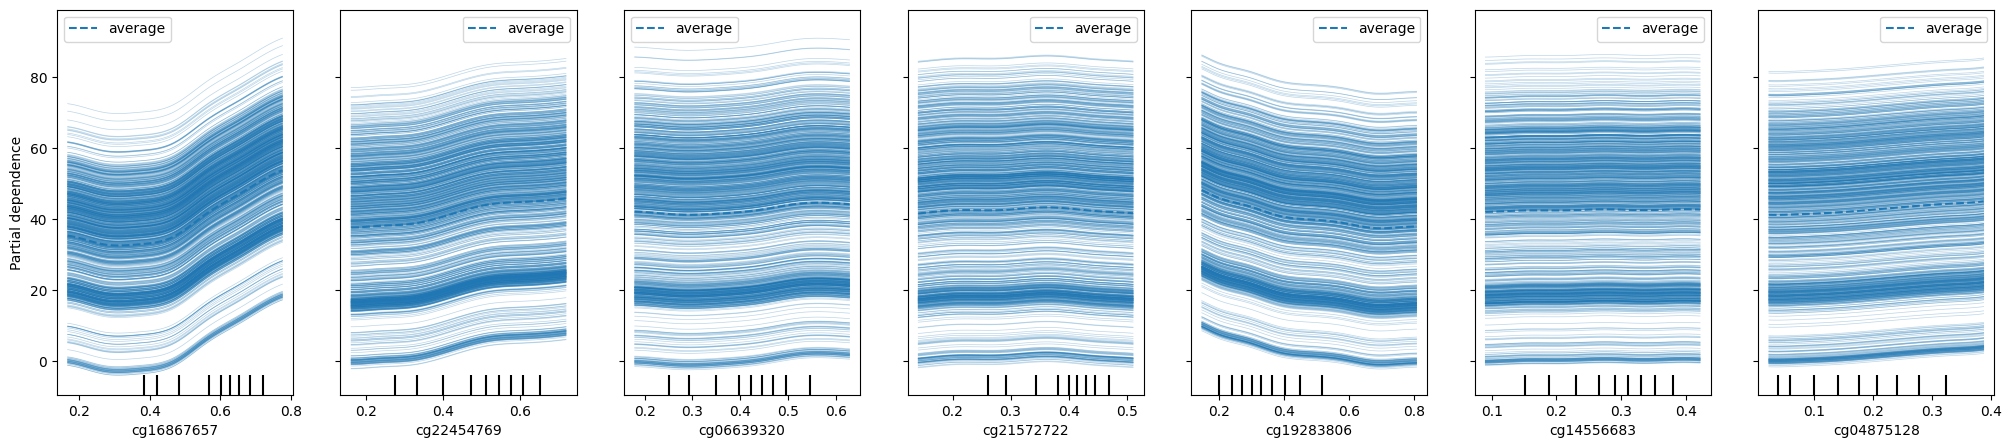

In [ ]:
# Import relevant tools

from sklearn.inspection import PartialDependenceDisplay

# Use optimal estimators from the model for k=50 and plot top 10 sites
# ridge_penalty = 3
# knots = 10

# Build Pipeline

pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("select", SelectKBest(score_func=f_regression, k=50)),
    ("spline", SplineTransformer(extrapolation="linear", degree=Degrees, n_knots=10)),
    ("ridge", Ridge(alpha=3))
])

Pipe = pipeline.fit(X_train, Y_train)

# retrieve 7 best sites

top_50_indices = Pipe.named_steps['select'].get_support(indices=True)
top_50_scores = Pipe.named_steps['select'].scores_[top_50_indices]
top_50_features = [methylation_site_names[i] for i in top_50_indices]

Top_50_df = pd.DataFrame({
    "site": top_50_features,
    "score": top_50_scores})

Top_50_df.sort_values(by=["score"], ascending=[False], inplace=True)
top_7_features = Top_50_df["site"].tolist()[:7]

# Create partial dependency plot for the top 10 sites

fig, ax = plt.subplots(figsize=(25, 5))
PD_plot = PartialDependenceDisplay.from_estimator(Pipe, X_train, top_7_features ,percentiles=(0.025, 0.975), n_cols=7, ax=ax, kind="both")

### **Conclusion**

The Above plots show the individual and average effects of methylenation level within the top 7 sites on age, while all other sites' levels are held constant. We can clearly see the benifit of using non-linearities to model the relationships between methylenation sites and age in some of these plots. While linear models are much more restricted, non-linear models can capture much more flexible relationships.

14.	Do you expect that performance could be improved by instead implementing the GAM with boosted trees of depth 1?

### **Expectation for use of GAM with tree stumps:**

Implementing a GAM with boosted tree stumps may indeed increase improve performance, beacuse the basis functions in splines can only capture smooth patterns, whereas a tree split is more flexible in the effects it can capture. This increased performance could however also come with a decrease in the interprebility of the model.

# Part VII: Glass-box vs Black-Box models.

15.	Similarly train and evaluate a “black-box” Random Forest regressor on the same dataset. How does the performance compare with the one of the “glass-box” models? Conclude on the merits of each method.

In [ ]:
# Import relevant tools

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

K_vals = [5, 10, 20, 30, 50, 100, 500, 1000]
Final_results_RF = []

for k in K_vals:

    print(f"K = {k}") # for sanity

    # Execute pipeline

    if (k > 100): # added subsample of features because the code Was taking too log to run for k=500 and k=1000

        RF_model = Pipeline([
              ("imputer", SimpleImputer(strategy="mean")),
              ("select", SelectKBest(score_func=f_regression, k=k)),
              ("RF", RandomForestRegressor(criterion="absolute_error", max_features=0.1))
              ])

    else:

        RF_model = Pipeline([
              ("imputer", SimpleImputer(strategy="mean")),
              ("select", SelectKBest(score_func=f_regression, k=k)),
              ("RF", RandomForestRegressor(criterion="absolute_error"))
              ])

    RF_model.fit(X_train, Y_train)
    y_test_pred = RF_model.predict(X_test)

    abs_errors = np.abs(Y_test - y_test_pred)
    Test_MAE = np.mean(abs_errors)
    Error_bar = np.std(abs_errors) / np.sqrt(len(Y_test))

    Final_results_RF.append({
        "number of features": k,
        "Test MAE": Test_MAE,
        "Error Bar": Error_bar
    })

Results_table_RF = pd.DataFrame(Final_results_RF)
Results_table_RF



K = 5
K = 10
K = 20
K = 30
K = 50
K = 100
K = 500
K = 1000


,number of features,Test MAE,Error Bar
0,5,5.090005,0.146352
1,10,4.711349,0.141140
2,20,4.621276,0.136579
3,30,4.623313,0.137970
4,50,4.479492,0.134338
5,100,3.869730,0.122701
6,500,3.352404,0.109759
7,1000,3.867415,0.109922


### **Comparison of black-box and glass-box models**

Black box model: random forest takes much longer to run since we want to grow many trees. Futhermore, it requires much more hyperparameter tuning compared to glass box models.

Glass box models: much more interpretable results and are simpler to tune (usually), however usually perform less well than RF in terms of perdiction.

In our case, the glass box models produced better results. This however is likely due to the fact that colab takes a long time to run, and therefore, the trees I grew were not very large (all of size 100). Futhermore, I could not complete a grid search without colab crashing. therefore, no real hyperparmeter tuning was done. I assume that with proper optimization of the model it would produce better results, in terms of MAE, compared to the glass box models.


## Bonus
Suggest and implement another approach to further improve the performance of the age predictor.

**I suggest using extreme gradient boosting (XGboost) - a powerful tree ensembles model which relies on gradient descent steps to minimize the loss and incorporates regularization. Also takes much less time to run compared to random forest. After some hyperparameter tuning, I obtained the following mode, which can likely be optimized further with more time**

In [ ]:
# Import relevant tools

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor as XGB

n_trees = 5000

XGB_model = Pipeline([
      ("imputer", SimpleImputer(strategy="median")),
      ("select", SelectKBest(score_func=f_regression, k=400)),
      ("XGB",  XGB(objective='reg:absoluteerror', n_estimators=n_trees, learning_rate=0.05, reg_alpha=0, reg_lambda=6,
                   subsample=1, max_depth=5, min_child_weight=2))
      ])

XGB_model.fit(X_train, Y_train)
y_test_pred = XGB_model.predict(X_test)

abs_errors = np.abs(Y_test - y_test_pred)
Test_MAE = np.mean(abs_errors)
Error_bar = np.std(abs_errors) / np.sqrt(len(Y_test))

Final_results_XGB = {
    "Test MAE": Test_MAE,
    "Error Bar": Error_bar
    }

Results_table_XGB = pd.DataFrame(Final_results_XGB, index=[0])
Results_table_XGB

,Test MAE,Error Bar
0,2.777354,0.093908
